# This notebook serves as the validation fo the correct implementation of the loss functions and their derivatives in CrysX-NN

# Plus, as a benchmark of the speed

## Run the following for Google colab 
then restart runtime

In [1]:
! pip install --upgrade --no-cache-dir https://github.com/manassharma07/crysx_nn/tarball/main
! pip install IPython==7.7.0

In [1]:
import numpy as np
import cupy as cp
np.show_config()
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.loss import MSE_loss_cupy, MSE_loss_grad_cupy
from crysx_nn.loss import MAE_loss_cupy, MAE_loss_grad_cupy
from crysx_nn.loss import BCE_loss_cupy, BCE_loss_grad_cupy
from crysx_nn.loss import CCE_loss_cupy, CCE_loss_grad_cupy
import crysx_nn
print('CrysX-NN',crysx_nn.__version__)

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Ensure that evertyhing is only using GPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [6]:
predictions_torch = 100*torch.rand((300,100),requires_grad=True)
predictions_torch = predictions_torch.cuda()
print(predictions_torch)
targets_torch = 100*torch.rand((300,100),requires_grad=True)
targets_torch = targets_torch.cuda()
print(targets_torch)

tensor([[29.2258, 87.6187, 19.6881,  ..., 49.0369, 71.7834, 10.4351],
        [48.7328, 66.5361, 27.8479,  ..., 16.8160, 92.2850, 92.9464],
        [94.1699, 98.8675, 44.8733,  ..., 54.0138,  2.8368, 39.5612],
        ...,
        [61.4717, 52.8253,  3.1129,  ..., 42.8266, 92.7233, 53.6993],
        [14.9089, 32.6019, 80.5383,  ..., 84.4834, 33.6072, 75.6791],
        [32.9999, 27.5597, 56.3838,  ..., 89.6906, 23.4592, 23.4126]],
       grad_fn=<MulBackward0>)
tensor([[62.7448,  9.9137, 66.7026,  ...,  8.0842, 29.7010, 57.1587],
        [13.9500, 93.6650, 62.5951,  ..., 45.7053, 26.2858, 77.5905],
        [ 4.6311, 59.5940, 21.1559,  ..., 38.3698, 45.2280,  7.6491],
        ...,
        [40.1032, 52.9378, 38.1149,  ..., 77.3309, 14.2676, 46.8648],
        [58.5428,  9.2976, 39.9114,  ..., 24.8336, 71.9753, 32.2934],
        [84.2658, 11.3994, 23.2578,  ..., 10.1903, 70.4625, 40.7174]],
       grad_fn=<MulBackward0>)


## Convert it to numpy for `crysx_nn`

In [7]:
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
print(predictions_crysx_nn.dtype)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
targets_cupy = cp.asarray(targets_crysx_nn)
print(targets_crysx_nn.dtype)

float32
float32


## Now finally convert it to a tensorflow tensor

In [8]:
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

## Benchmark MSE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [9]:
# Torch
mse_loss_func = torch.nn.MSELoss()
mse_torch_value = mse_loss_func(predictions_torch, targets_torch)

# CrysX
mse_crysx_nn_value = MSE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
print(type(mse_crysx_nn_value))

# Tensorflow
mse_tf_func = tf.keras.losses.MeanSquaredError()
mse_tf_value = mse_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(mse_torch_value.cpu().detach().numpy() - mse_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(mse_torch_value.cpu().detach().numpy() - cp.asnumpy(mse_crysx_nn_value)).max())

<class 'float'>
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 5.8591345350578194e-05


### Compare performance with arrays of different sizes

In [10]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    predictions_cupy = cp.asarray(predictions_crysx_nn)
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    targets_cupy = cp.asarray(targets_crysx_nn)
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    mse_loss_func = torch.nn.MSELoss()
    mse_torch_value = mse_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 500 -o mse_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    mse_crysx_nn_value = MSE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    time = %timeit -n 500 -o MSE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    mse_tf_func = tf.keras.losses.MeanSquaredError()
    mse_tf_value = mse_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 500 -o mse_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(mse_torch_value.cpu().detach().numpy() - mse_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(mse_torch_value.cpu().detach().numpy() - cp.asnumpy(mse_crysx_nn_value)).max())

18 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
8.95 µs ± 851 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
160 µs ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 1.0936111266346416e-05
74.8 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
85.8 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
322 µs ± 9.56 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 0.00012207031
Max abs diff b/w torch and CrysX 0.00012443146670193528
704 µs ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
242 µs ± 49.9 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.12 ms ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 8.844012882036623e-05
1.63 ms ± 99.9 µs p

### Plot the results

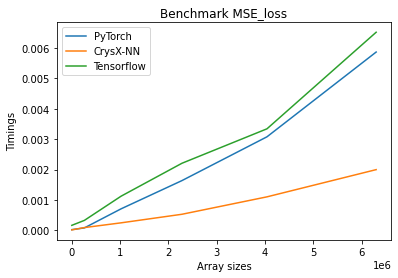

In [11]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark MSE_loss (GPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
from google.colab import files
plt.savefig("MSE_loss_GPU.png", transparent=True)
files.download("MSE_loss_GPU.png")

### Validate gradients

In [12]:
def tf_mse_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        mse_tf_func = tf.keras.losses.MeanSquaredError()
        mse_tf_value = mse_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(mse_tf_value, predictions_tf)
    return grad#.numpy()

In [13]:
# Torch input
predictions_torch = 10000*torch.rand((2000,3000),requires_grad=True)
targets_torch = 10000*torch.rand((2000,3000),requires_grad=True)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
targets_cupy = cp.asarray(targets_crysx_nn)
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mse_loss_func = torch.nn.MSELoss()
mse_torch_value = mse_loss_func(predictions_torch, targets_torch)
mse_torch_value.backward()
gradientTorch = torch.autograd.grad(mse_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = MSE_loss_grad_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]

# Tensorflow
gradientTF = tf_mse_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - cp.asnumpy(gradientCrysX_NN)).max())

Max abs diff b/w torch and tf 4.656613e-10
Max abs diff b/w torch and CrysX 2.3283064e-10


## Benchmark BCE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [14]:
# Torch input
predictions_torch = torch.rand((2000,3000),requires_grad=True)
# print(predictions_torch)
targets_torch = torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
targets_cupy = cp.asarray(targets_crysx_nn)
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)

# CrysX
bce_crysx_nn_value = BCE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
# print(bce_crysx_nn_value)

# Tensorflow
bce_tf_func = tf.keras.losses.BinaryCrossentropy()
bce_tf_value = bce_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(bce_torch_value.cpu().detach().numpy() - bce_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(bce_torch_value.cpu().detach().numpy() - cp.asnumpy(bce_crysx_nn_value)).max())

Max abs diff b/w torch and tf 1.847744e-06
Max abs diff b/w torch and CrysX 1.7121086205440506e-06


### Compare performance with arrays of different sizes

In [15]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = torch.randint(low=0,high=2, size=(n_size,n_size)).float()
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    predictions_cupy = cp.asarray(predictions_crysx_nn)
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    targets_cupy = cp.asarray(targets_crysx_nn)
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    bce_loss_func = torch.nn.BCELoss()
    bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 100 -o bce_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    bce_crysx_nn_value = BCE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    time = %timeit -n 100 -o BCE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    bce_tf_func = tf.keras.losses.BinaryCrossentropy()
    bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 100 -o bce_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(bce_torch_value.cpu().detach().numpy() - bce_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(bce_torch_value.cpu().detach().numpy() - cp.asnumpy(bce_crysx_nn_value)).max())

25 µs ± 3.88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.3 µs ± 2.76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
364 µs ± 67.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 1.0728836e-06
Max abs diff b/w torch and CrysX 1.0268600559859564e-06
875 µs ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
862 µs ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.17 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 1.4901161e-06
Max abs diff b/w torch and CrysX 1.496214937279916e-06
3.67 ms ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.02 ms ± 58.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12 ms ± 877 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 1.5497208e-06
Max abs diff b/w torch and CrysX 1.4853874583664606e-06
7.89 ms ± 

### Plot the results

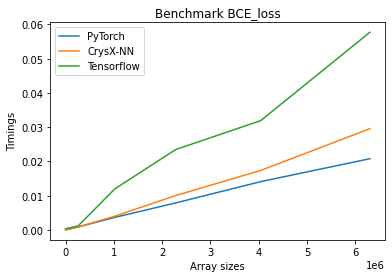

In [16]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark BCE_loss (GPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
plt.savefig("BCE_loss_GPU.png", transparent=True)
files.download("BCE_loss_GPU.png")

### Validate gradients

In [17]:
def tf_bce_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        bce_tf_func = tf.keras.losses.BinaryCrossentropy()
        bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(bce_tf_value, predictions_tf)
    return grad#.numpy()

In [18]:
nSamples = 2000
nOutputs = 3000#nClasess
# Torch input
predictions_torch_ = torch.rand((nSamples,nOutputs),requires_grad=True)
# print(predictions_torch)
# Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
# Therefore, apply a softmax on them
m = torch.nn.Softmax()
predictions_torch = m(predictions_torch_)
# print(predictions_torch)
# Generate random one hot vectors matrix
# No. of classes
n = nOutputs
target_indices = torch.randint(1,n, size=(1,nSamples)).reshape(nSamples) # Get a 1D tensor index of size =nSamples=2000
# print(target_indices)
# print(target_indices.shape)
# Convert the index tensor to one-hot encoded vectors matrix
target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# print(targets_torch.shape)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
targets_cupy = cp.asarray(targets_crysx_nn)
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
bce_torch_value.backward()
gradientTorch = torch.autograd.grad(bce_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = BCE_loss_grad_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]

# Tensorflow
gradientTF = tf_bce_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - cp.asnumpy(gradientCrysX_NN)).max())

C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Max abs diff b/w torch and tf 4.490139e-07
Max abs diff b/w torch and CrysX 1.1641532e-10


## Benchmark MAE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError

CrysX-NN doesn't return values averaged over samples. So take care of that.

In [19]:
# Torch
predictions_torch = 100*torch.rand((300,100),requires_grad=True)
targets_torch = 100*torch.rand((300,100),requires_grad=True)
# CrysX
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
targets_cupy = cp.asarray(targets_crysx_nn)
# TensorFlow
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mae_loss_func = torch.nn.L1Loss()
mae_torch_value = mae_loss_func(predictions_torch, targets_torch)

# CrysX
mae_crysx_nn_value = MAE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
print(type(mae_crysx_nn_value))

# Tensorflow
mae_tf_func = tf.keras.losses.MeanAbsoluteError()
mae_tf_value = mae_tf_func(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(mae_torch_value.cpu().detach().numpy() - mae_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(mae_torch_value.cpu().detach().numpy() - cp.asnumpy(mae_crysx_nn_value)).max())

<class 'float'>
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 9.815693147174898e-08


### Compare performance with arrays of different sizes

In [20]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    targets_torch = 100*torch.rand((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    predictions_cupy = cp.asarray(predictions_crysx_nn)
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    targets_cupy = cp.asarray(targets_crysx_nn)
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    mae_loss_func = torch.nn.L1Loss()
    mae_torch_value = mae_loss_func(predictions_torch, targets_torch)
    time = %timeit -n 300 -o mae_loss_func(predictions_torch, targets_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    mae_crysx_nn_value = MAE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    time = %timeit -n 300 -o MAE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    mae_tf_func = tf.keras.losses.MeanAbsoluteError()
    mae_tf_value = mae_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 300 -o mae_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(mae_torch_value.cpu().detach().numpy() - mae_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(mae_torch_value.cpu().detach().numpy() - cp.asnumpy(mae_crysx_nn_value)).max())

23.5 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
8.14 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
183 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 2.1600723272285904e-06
192 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
58 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
402 µs ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 3.8146973e-06
Max abs diff b/w torch and CrysX 3.334936025112256e-07
1.33 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
150 µs ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
2.26 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 300 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 1.8503593182117584e-06
2.55 ms ± 273 µs per

### Plot the results

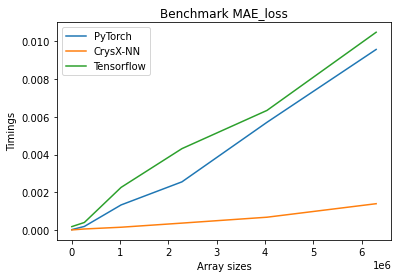

In [21]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark MAE_loss (GPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
plt.savefig("MAE_loss_GPU.png", transparent=True)
files.download("MAE_loss_GPU.png")

### Validate gradients

In [22]:
def tf_mae_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        mae_tf_func = tf.keras.losses.MeanAbsoluteError()
        mae_tf_value = mae_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(mae_tf_value, predictions_tf)
    return grad#.numpy()

In [23]:
# Torch input
predictions_torch = 10000*torch.rand((2000,3000),requires_grad=True)
targets_torch = 10000*torch.rand((2000,3000),requires_grad=True)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
targets_cupy = cp.asarray(targets_crysx_nn)
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
mae_loss_func = torch.nn.L1Loss()
mae_torch_value = mae_loss_func(predictions_torch, targets_torch)
mae_torch_value.backward()
gradientTorch = torch.autograd.grad(mae_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = MAE_loss_grad_cupy(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]
# print(gradientCrysX_NN)


# Tensorflow
gradientTF = tf_mae_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - cp.asnumpy(gradientCrysX_NN)).max())

Max abs diff b/w torch and tf 1.4210855e-14
Max abs diff b/w torch and CrysX 4.2079286565503357e-16


## Benchmark CCE_loss

### Confirm that all frameworks give the same results

PyTorch expects predictions first then targets

PyTorch - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

TensorFlow expects targets first then predictions

Tensorflow - https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

CrysX-NN doesn't return values averaged over samples. So take care of that.

<b>Note:</b> TensorFlow and CrysX-NN expect one-hot encoded vectors.
<b>Note:</b> Unfortunately, PyTorch computes the Cross Entropy in a weird fashion. It expects the inputs to not be probabilities. Rather it computes the probabilities from the inputs using the Softmax function and then returns the Cross Entropy Loss.https://stackoverflow.com/questions/49390842/cross-entropy-in-pytorch

Unrelated but useful info some of the answers and comments for future reference: https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances

In [24]:
nSamples = 2000
nOutputs = 3000 #nClasess
# Torch input
predictions_torch_ = torch.rand((nSamples,nOutputs),requires_grad=True)
# print(predictions_torch)
# Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
# Therefore, apply a softmax on them
m = torch.nn.Softmax()
predictions_torch = m(predictions_torch_)
# print(predictions_torch)
# Generate random one hot vectors matrix
# No. of classes
n = nOutputs
target_indices = torch.randint(1,n, size=(1,nSamples)).reshape(nSamples) # Get a 1D tensor index of size =nSamples=2000
# print(target_indices)
# print(target_indices.shape)

# Convert the index tensor to one-hot encoded vectors matrix
target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# print(targets_torch.shape)

# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
targets_crysx_nn = targets_torch.cpu().detach().numpy()

# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
cce_loss_func = torch.nn.CrossEntropyLoss()
# cce_loss_func = torch.nn.NLLLoss()
# cce_torch_value = cce_loss_func(predictions_torch_, targets_torch) # Don't use one-hot vectors for PyTorch
cce_torch_value = cce_loss_func(predictions_torch_, target_indices) # Use the class/target indices directly for Pytorch
# print(cce_torch_value)

# CrysX
# Default epsilon=1e-9 (gives exactly the same answer as tensorflow)
cce_crysx_nn_value = CCE_loss_cupy(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
# print(cce_crysx_nn_value)

# Tensorflow
cce_tf_func = tf.keras.losses.CategoricalCrossentropy()
cce_tf_value = cce_tf_func(targets_tf, predictions_tf)
# print(cce_tf_value)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(cce_torch_value.cpu().detach().numpy() - cce_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(cce_torch_value.cpu().detach().numpy() - cp.asnumpy(cce_crysx_nn_value)).max())


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 2.909796011252297e-06


### Compare performance with arrays of different sizes

In [25]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    predictions_torch_ = torch.rand((n_size,n_size),requires_grad=True)
    # Predictions are supposed to be probabilities from 0 to 1, summing upto 1.
    # Therefore, apply a softmax on them
    m = torch.nn.Softmax()
    predictions_torch = m(predictions_torch_)
    # Generate random one hot vectors matrix
    # No. of classes
    n = n_size
    target_indices = torch.randint(1,n, size=(1,n_size)).reshape(n_size) # Get a 1D tensor index of size =nSamples=2000
    # Convert the index tensor to one-hot encoded vectors matrix
    target_one_hot = torch.nn.functional.one_hot(target_indices, n) # size=(4,7,n)
    targets_torch = target_one_hot.float() # torch.randint(low=0,high=2, size=(2000,3000)).float()
    # CrysX-NN input
    predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
    predictions_cupy = cp.asarray(predictions_crysx_nn)
    targets_crysx_nn = targets_torch.cpu().detach().numpy()
    # Tensorflow input
    predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
    targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    cce_loss_func = torch.nn.BCELoss()
    cce_torch_value = bce_loss_func(predictions_torch_, target_indices)
    time = %timeit -n 100 -o bce_loss_func(predictions_torch_, target_indices)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    cce_crysx_nn_value = CCE_loss(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    time = %timeit -n 100 -o CCE_loss(predictions_cupy, targets_cupy)/predictions_cupy.shape[0]
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    cce_tf_func = tf.keras.losses.CategoricalCrossentropy()
    cce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    time = %timeit -n 100 -o bce_tf_func(targets_tf, predictions_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    print('Size:', predictions_crysx_nn.shape)
    #Diff b/w tf and torch
    print('Max abs diff b/w torch and tf', abs(cce_torch_value.cpu().detach().numpy() - cce_tf_value.numpy()).max())
    #Diff b/w crysx_nn and torch
    print('Max abs diff b/w torch and CrysX', abs(cce_torch_value.cpu().detach().numpy() - cp.asnumpy(cce_crysx_nn_value)).max())

16 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.14 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
351 µs ± 58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (10, 10)
Max abs diff b/w torch and tf 4.7683716e-07
Max abs diff b/w torch and CrysX 4.065944689823908e-07
805 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
867 µs ± 41.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.12 ms ± 85.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (510, 510)
Max abs diff b/w torch and tf 1.4305115e-06
Max abs diff b/w torch and CrysX 1.4453722541052372e-06
3.46 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.34 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Size: (1010, 1010)
Max abs diff b/w torch and tf 1.7881393e-06
Max abs diff b/w torch and CrysX 1.8270767787598174e-06
7.51 ms ± 10

### Plot the results

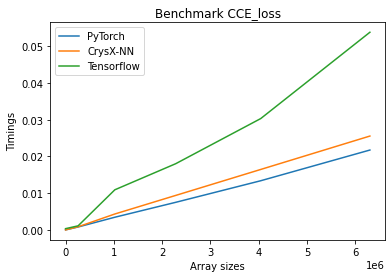

In [26]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Average Time (seconds)')
plt.title('Benchmark CCE_loss (GPU)')
# plt.show()
plt.subplots_adjust(left=0.15)
plt.savefig("CCE_loss_GPU.png", transparent=True)
files.download("CCE_loss_GPU.png")

### Validate gradients

In [27]:
def tf_bce_grad(targets_tf, predictions_tf):
    with tf.GradientTape() as g:
        g.watch(predictions_tf)
        bce_tf_func = tf.keras.losses.BinaryCrossentropy()
        bce_tf_value = bce_tf_func(targets_tf, predictions_tf)
    grad = g.gradient(bce_tf_value, predictions_tf)
    return grad#.numpy()

In [28]:
# Torch input
predictions_torch = torch.rand((2000,3000),requires_grad=True)
# print(predictions_torch)
targets_torch = torch.randint(low=0,high=2, size=(2000,3000)).float()
# print(targets_torch)
# CrysX-NN input
predictions_crysx_nn = predictions_torch.cpu().detach().numpy()
predictions_cupy = cp.asarray(predictions_crysx_nn)
targets_crysx_nn = targets_torch.cpu().detach().numpy()
# Tensorflow input
predictions_tf = tf.convert_to_tensor(predictions_crysx_nn, dtype=tf.float32)
targets_tf = tf.convert_to_tensor(targets_crysx_nn, dtype=tf.float32)

# Torch
bce_loss_func = torch.nn.BCELoss()
bce_torch_value = bce_loss_func(predictions_torch, targets_torch)
bce_torch_value.backward()
gradientTorch = torch.autograd.grad(bce_loss_func(predictions_torch,targets_torch),predictions_torch)[0]
# print(gradientTorch)

# CrysX
gradientCrysX_NN = BCE_loss_grad(predictions_crysx_nn, targets_crysx_nn)/predictions_crysx_nn.shape[0]

# Tensorflow
gradientTF = tf_bce_grad(targets_tf, predictions_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientTorch.cpu().detach().numpy() - gradientTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientTorch.cpu().detach().numpy() - cp.asnumpy(gradientCrysX_NN)).max())

C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\crysx_nn\loss.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return -(np.nan_to_num(np.divide(targets,predictions,dtype=targets.dtype))-np.nan_to_num(np.divide(1.-targets,1.-predictions,dtype=targets.dtype)))/predictions.shape[1]


Max abs diff b/w torch and tf 166666.67
Max abs diff b/w torch and CrysX 5.6713723e+31
